# Análisis de Errores en Valores en SECOP
    Autores: Heriberto Felizzola y Nicolas Arrieta
    Fecha elaboración: 12/12/2020

En el siguiente análisis se presenta una descripción de los errores encontrados en las variables referentes al valor del contrato, es decir, valor estimado, valor establecido en el contrato y las adiciones. La estrategia para obtener las anomalias fue por medio de varias consultas que permiten capturar los contratos que presentan una alta probabilidad de error. Sin embargo, es necesario revisar detenidamente cada uno de los contratos que se obtienen en las consultas para establecer con más certeza si se trata de un error. Debido a que en este proceso es necesario revisar manualmente los archivos presentes en la plataforma online, el tiempo requerido es bastante, por lo tanto, se revisó una muestra de cada consulta.

Tanto los conjuntos de datos y el código de este archivo están disponibles en el repositorio de GitHub [Errores-Valor-SECOP](https://github.com/NicolasArrietaC/Errores-Valor-SECOP).



In [31]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Conjunto de datos

En esta revisión se obtuvo dos conjuntos de datos, donde cada uno hace referencia a los contratos revisados en cada una de las plataformas disponibles de contratación pública en Colombia, SECOP I y SECOP II.

Por parte del SECOP I se registran 1155 registros revisados y 23 atributos. En la siguiente tabla se presenta un detalle de conjunto de datos. Cabe resaltar que los atributo 0-10 es información obtenida del SECOP por medio de [Datos Abiertos de Colombia](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-I/xvdy-vvsk), mientras que los restantes 11-22 son creados para caracterizar los errores encontrados en la revisión.

In [33]:
secop_i = pd.read_csv('Datasets\Errores_valor_secop_i_csl.csv')
secop_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uid                     1156 non-null   object 
 1   nivel_entidad           1156 non-null   object 
 2   orden_entidad           1156 non-null   object 
 3   tipo_contrato           1156 non-null   object 
 4   nombre_entidad          1156 non-null   object 
 5   dpto_entidad            1156 non-null   object 
 6   munp_entidad            1156 non-null   object 
 7   cuantia_contrato_reg    1155 non-null   object 
 8   valor_adicion_reg       693 non-null    object 
 9   valor_total_reg         1155 non-null   object 
 10  ruta_web                1156 non-null   object 
 11  error_cuantia_proceso   1152 non-null   float64
 12  tipo_error_proceso      179 non-null    object 
 13  error_cuantia_contrato  1152 non-null   float64
 14  tipo_error_contrato     477 non-null    

Con respecto a SECOP II, se implementó el mismo método, sin embargo, de acuerdo a la forma en que esta diseñada la base de datos se obtuvieron 17 atributos, 5 menos con relación a SECOP I. En este caso, se revisaron 357 contratos y la siguiente tabla presenta un detalle de los atributos.

Los atributos del 0-8 representan la información obtenida en el portal de [Datos Abiertos de Colombia](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Contratos-Electr-nicos/jbjy-vk9h) y el restante 9-17 hacen referencia a la caracterización del error.

In [34]:
secop_ii = pd.read_csv('Datasets\Errores_valor_secop_ii_csl.csv')
secop_ii.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   uid                        357 non-null    object 
 1   nombre_entidad             357 non-null    object 
 2   dpto_entidad               357 non-null    object 
 3   munp_entidad               357 non-null    object 
 4   orden_entidad              357 non-null    object 
 5   tipo_contrato              357 non-null    object 
 6   tipo_proceso               357 non-null    object 
 7   valor_contrato_reg         357 non-null    object 
 8   ruta_web                   357 non-null    object 
 9   error_valor_estimado       356 non-null    float64
 10  tipo_error_valor_estimado  24 non-null     object 
 11  error_valor_contrato       356 non-null    float64
 12  tipo_error_valor_contrato  59 non-null     object 
 13  valor_contrato_real        62 non-null     object 

## Consultas de detección de anomalias
En este estudio se aplicaron 4 tipo de consultas para obtener los contratos con anomalias:
* _Diferencia cuantia proceso y valor contrato_: En la mayoria de los casos la cuantia del proceso es cercano al valor del contrato. Por lo tanto, esta consulta obtiene los contratos que presentan una desproporcionalidad, ya sea alta o baja entre los dos atributos.
* _Ceros adicionales_: Un error muy frecuente es agregar ceros a la derecha en el valor del contrato, causado por digitación o diferencia en el simbolo decimal. Esta consulta se trata de obtener los contratos con valores que presentan una racha de ceros a la derecha. En este caso, se obtuvieron los contratos que presentan una racha de mínimo 6 ceros.
* _Adiciones altas y bajas_: De igual forma que en la primera consulta, existen desproporcionalidades entre el valor del contrato y las adiciones, donde puede que una adición sea insignificante o demasiado alta a comparación del valor del contrato.
* _Cuantia contrato cercano a cero_: Los contratos con valores cercanos al cero, e incluyendo al mismo cero, tienen una porporción considerable. Aunque algunos de estos contratos puede que no se trate de un error, porque el contrato puede ser simbolico, por lo tanto, es necesario diferenciar estos contratos a los que realmente son un error.

En el caso de SECOP I se aplicaron todas las consultas. A continuación se presenta un análisis de los resultados con relación a las consultas.

In [35]:
# Creacion del atributo relaciones del error (rel_error) para secop i
condiciones = [
    (secop_i["error_cuantia_proceso"].eq(1) &\
     secop_i["error_cuantia_contrato"].eq(0) & secop_i["error_adicion"].eq(0)),
    (secop_i["error_cuantia_proceso"].eq(1) &\
     secop_i["error_cuantia_contrato"].eq(0) & secop_i["error_adicion"].eq(1)),
    (secop_i["error_cuantia_proceso"].eq(1) &\
     secop_i["error_cuantia_contrato"].eq(1) & secop_i["error_adicion"].eq(1)),
    (secop_i["error_cuantia_proceso"].eq(0) &\
     secop_i["error_cuantia_contrato"].eq(0) & secop_i["error_adicion"].eq(1)),
    (secop_i["error_cuantia_proceso"].eq(0) &\
     secop_i["error_cuantia_contrato"].eq(1) & secop_i["error_adicion"].eq(1)),
    (secop_i["error_cuantia_proceso"].eq(0) &\
     secop_i["error_cuantia_contrato"].eq(0) & secop_i["error_adicion"].eq(0)),
    (secop_i["error_cuantia_proceso"].eq(0) &\
     secop_i["error_cuantia_contrato"].eq(1) & secop_i["error_adicion"].eq(0)),
    (secop_i["error_cuantia_proceso"].eq(1) &\
     secop_i["error_cuantia_contrato"].eq(1) & secop_i["error_adicion"].eq(0))
]

valores = ["proceso", "proceso & adición", "proceso & inicial & adición",\
           "adición", "inicial & adición", "ninguna", "inicial", "proceso & inicial"]

secop_i["rel_error"] = np.select(condiciones, valores)

# Creación del atributo que clasifica si hubo o no error
secop_i = secop_i.assign(es_error = secop_i['rel_error']\
                    .map(lambda rel_error: 'con error' if rel_error != 'ninguna' else 'sin error'))

Inicialmente, de los 1156 contratos de SECOP I se identificaron 56.8% (657) contratos con error y un 43.2% (499) de contratos sin error.

In [36]:
secop_i.groupby('es_error')['es_error'].count()

es_error
con error    657
sin error    499
Name: es_error, dtype: int64

Desde una vista más detallada, se puede observar la cantidad de contratos con y sin error para cada una de las consultas propuestas. En la siguiente figura se observa como las consultas de _ceros adicionales_ y _diferencia cuantia proceso y valor del contrato_ tienen un mejor acierto en identificar los contratos  con error, mientras que las adiciones altas y bajas tienen valores similares. Por otro lado, la _cuantia de contratos cercanos a cero_ presenta una cantidad de contratos con error muy bajo.

<Figure size 360x720 with 0 Axes>

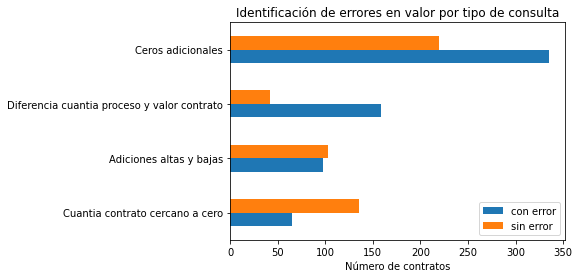

In [37]:
plt.figure(figsize = (5, 10))

secop_i.groupby(['tipo_consulta', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .plot(kind = 'barh', title = 'Identificación de errores en valor por tipo de consulta')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

Con respecto a SECOP II, cabe aclarar que no se efectúo la consulta de _diferencia cuantia proceso y valor del contrato_, sin embargo, las otras consultas presentan el mismo diseño.

In [38]:
# Creacion del atributo relaciones del error (rel_error) para secop ii
condiciones = [
    (secop_ii["error_valor_estimado"].eq(1) &\
     secop_ii["error_valor_contrato"].eq(0) & secop_ii["error_adicion"].eq(0)),
    (secop_ii["error_valor_estimado"].eq(1) &\
     secop_ii["error_valor_contrato"].eq(0) & secop_ii["error_adicion"].eq(1)),
    (secop_ii["error_valor_estimado"].eq(1) &\
     secop_ii["error_valor_contrato"].eq(1) & secop_ii["error_adicion"].eq(1)),
    (secop_ii["error_valor_estimado"].eq(0) &\
     secop_ii["error_valor_contrato"].eq(0) & secop_ii["error_adicion"].eq(1)),
    (secop_ii["error_valor_estimado"].eq(0) &\
     secop_ii["error_valor_contrato"].eq(1) & secop_ii["error_adicion"].eq(1)),
    (secop_ii["error_valor_estimado"].eq(0) &\
     secop_ii["error_valor_contrato"].eq(0) & secop_ii["error_adicion"].eq(0)),
    (secop_ii["error_valor_estimado"].eq(0) &\
     secop_ii["error_valor_contrato"].eq(1) & secop_ii["error_adicion"].eq(0)),
    (secop_ii["error_valor_estimado"].eq(1) &\
     secop_ii["error_valor_contrato"].eq(1) & secop_ii["error_adicion"].eq(0))
]

valores = ["estimado", "estimado & adición", "estimado & inicial & adición",\
           "adición", "inicial & adición", "ninguna", "inicial", "estimado & inicial"]

secop_ii["rel_error"] = np.select(condiciones, valores)

# Creación del atributo que clasifica si hubo o no error
secop_ii = secop_ii.assign(es_error = secop_ii['rel_error']\
                    .map(lambda rel_error: 'con error' if rel_error != 'ninguna' else 'sin error'))

La cantidad de contratos con error en SECOP II presenta una tasa más baja que en SECOP I, es así como existe un 25.2% (90) de contratos que se identificaron con error en alguno de los tres atributos de valor, mientras que un 74.8% (267) de los contratos no presentan un problema en los valores.

In [39]:
secop_ii.groupby('es_error')['es_error'].count()

es_error
con error     90
sin error    267
Name: es_error, dtype: int64

Al analizar la cantidad de contratos que presentan error por tipo de consulta presentadas en la siguiente gráfica, se puede observar que la _cuantía contrato cercano a cero_ es la que tienen mayor cantidad de estos contratos, seguidamente está _ceros adicionales_ y por último las _adiciones altas y bajas_. A partir de esto se puede resaltar dos puntos importantes. La primera es que todas las consultas presentan una cantidad menor de contratos con error a comparación del total por consulta, lo que refleja los avances en calidad de datos que realizó __Colombia Compra Eficiente__ en SECOP II. En segundo lugar, la consulta que presentó mayor casos de errores fue la que presentó menores casos en SECOP I. Esto puede describir las diferencias en que están desarrolladas las plataformas y cómo una puede retroalimentar mejoras en el registro de la otra.

<Figure size 360x720 with 0 Axes>

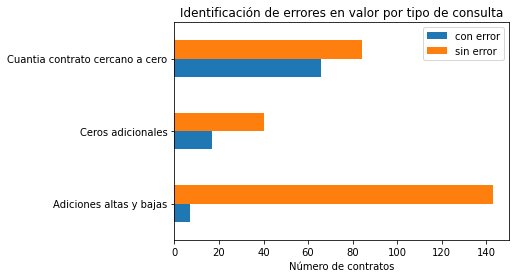

In [40]:
plt.figure(figsize = (5, 10))

secop_ii.groupby(['tipo_consulta', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .plot(kind = 'barh', title = 'Identificación de errores en valor por tipo de consulta')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

## Análisis Exploratorio
A continuación se presenta un análisis sobre la presencia de los errores en valor mediante su causa y las características de las entidades.
### Tipo de error
Los errores pueden ser generados por diferentes causas: simbologia del decimal, digitación, falta de actualizaciones, entre otras. Por lo que además de identificar el error, es importante conocer su fuente y establecer mejoras. A partir de esto, el conjunto de datos tiene definido si el error se generó en más de uno de los tres atributos de valor, en adición, se agregó atributos que describen el tipo de error.

En la siguiente figura se presenta la cantidad de contratos con errores en las variables de valor para cada una de las consultas. A partir de esto, se puede observar con claridad que el atributo de _valor del contrato_ es el que presenta más errores a comparación del _valor del proceso_ y las _adiciones_. 

Text(0, 0.5, '')

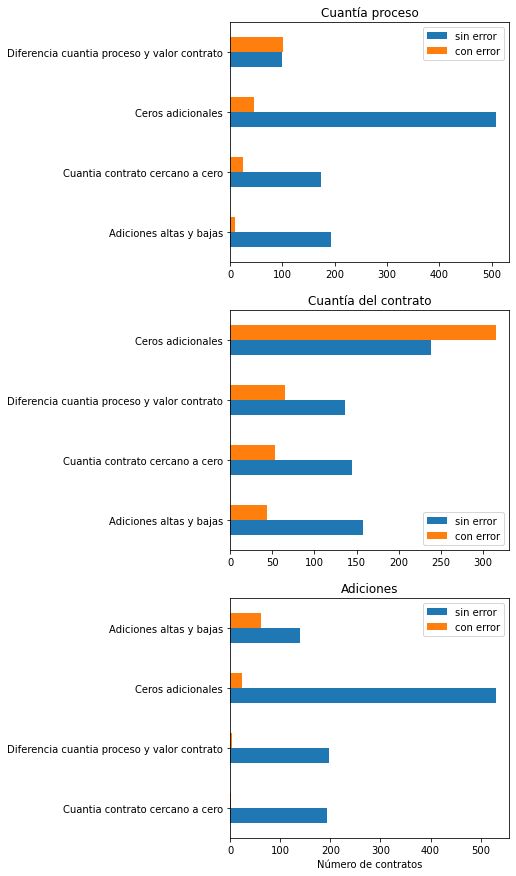

In [41]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (5,15))

col_error = ['error_cuantia_proceso', 'error_cuantia_contrato', 'error_adicion']
col_error_lb = ['Cuantía proceso', 'Cuantía del contrato', 'Adiciones']

for pl, col, col_lb in zip(ax.flat, col_error, col_error_lb):
    secop_i.groupby(['tipo_consulta', col])[col]\
        .count()\
        .unstack(col)\
        .fillna(0)\
        .sort_values(by = 1)\
        .plot(kind='barh', ax=pl)
    pl.set_ylabel('')
    pl.set_title('{}'.format(col_lb))
    pl.legend(['sin error', 'con error'], title = '')

plt.xlabel('Número de contratos')
plt.ylabel('')

Por otro lado, al observar en la siguiente figura los tipos de errores para cada uno de los atributos y las consultas, se identifican varias cosas importantes. En primer lugar, aunque cada consulta está orientada para cada problema en específico, se obtuvieron otro tipo de errores adicionales a los que se esperaban, por ejemplo, en la _cuantía del proceso_ se identificó la mayoría de contratos con agregación de ceros por medio de la consulta de ceros adicionales, sin embargo, existe una proporción considerable de contratos que presentaron este problema identificados mediante las consultas de _diferencia en cuantía proceso y valor contrato_, de esta forma sucede con casi todos los tipos de error. En segundo lugar, se puede observar con claridad que una o dos consultas sobresale para cada una de los atributos. Es así como en la _cuantía del proceso_ se observa una gran cantidad de contratos indentificados por medio de la consulta de _diferencia en cuantía proceso y valor contrato_, para el caso de la _cuantía del contrato_ se observa una gran proporción por la consulta de _ceros adicionales_ y con respecto a las adiciones sobresale la consulta de adiciones altas y bajas.

Text(0, 0.5, '')

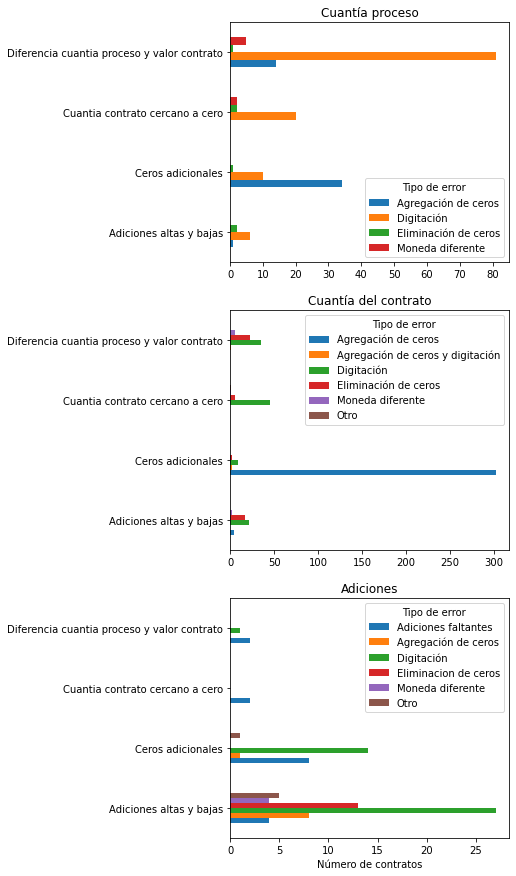

In [42]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (5,15))

col_error = ['tipo_error_proceso', 'tipo_error_contrato', 'tipo_error_adicion']
col_error_lb = ['Cuantía proceso', 'Cuantía del contrato', 'Adiciones']

for pl, col, col_lb in zip(ax.flat, col_error, col_error_lb):
    secop_i.groupby(['tipo_consulta', col])[col]\
        .count()\
        .unstack(col)\
        .fillna(0)\
        .plot(kind='barh', ax=pl)
    pl.set_ylabel('')
    pl.set_title('{}'.format(col_lb))
    pl.legend(title = 'Tipo de error')

plt.xlabel('Número de contratos')
plt.ylabel('')

Por el lado de SECOP II se puede obtener el mismo comportamiento que en SECOP I, pero con menor proporción. En este caso la variable de _valor del contrato_ posee una mayor cantidad de contratos con error, aunque la diferencia es muy poca con relación al _valor estimado_.

Text(0, 0.5, '')

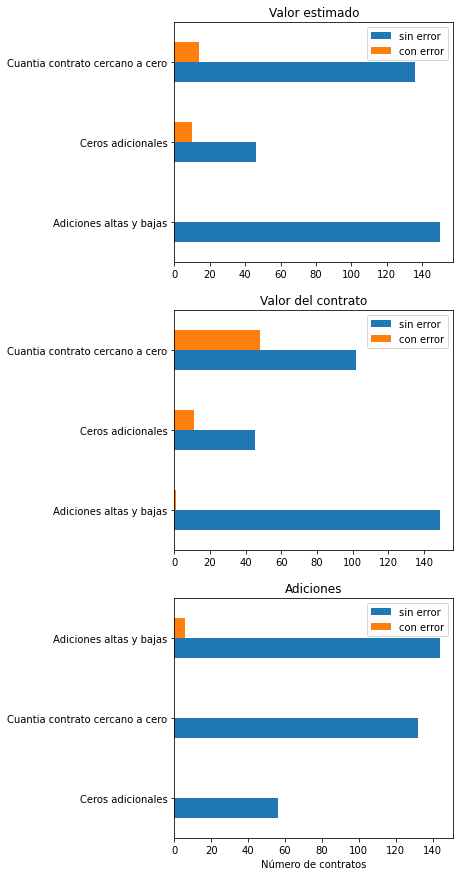

In [43]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (5,15))

col_error = ['error_valor_estimado', 'error_valor_contrato', 'error_adicion']
col_error_lb = ['Valor estimado', 'Valor del contrato', 'Adiciones']

for pl, col, col_lb in zip(ax.flat, col_error, col_error_lb):
    secop_ii.groupby(['tipo_consulta', col])[col]\
        .count()\
        .unstack(col)\
        .fillna(0)\
        .sort_values(by = 1)\
        .plot(kind='barh', ax = pl)
    pl.set_ylabel('')
    pl.set_title('{}'.format(col_lb))
    pl.legend(['sin error', 'con error'], title = '')

plt.xlabel('Número de contratos')
plt.ylabel('')

Con respecto al tipo de error, se presentan menores causas de los errores, sin embargo, se presenta que en las tres variables el error con mayor número es el de digitación.

Text(0, 0.5, '')

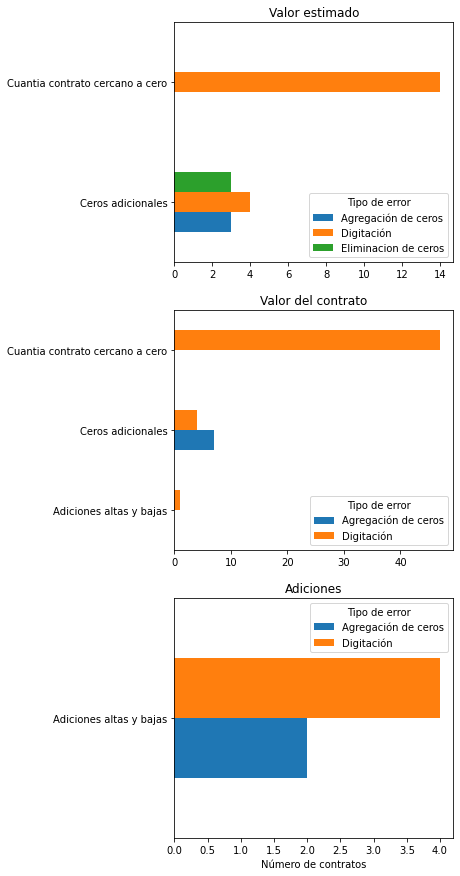

In [44]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (5,15))

col_error = ['tipo_error_valor_estimado', 'tipo_error_valor_contrato', 'tipo_error_adicion']
col_error_lb = ['Valor estimado', 'Valor del contrato', 'Adiciones']

for pl, col, col_lb in zip(ax.flat, col_error, col_error_lb):
    secop_ii.groupby(['tipo_consulta', col])[col]\
        .count()\
        .unstack(col)\
        .fillna(0)\
        .plot(kind = 'barh', ax = pl)
    pl.set_ylabel('')
    pl.set_title('{}'.format(col_lb))
    pl.legend(title = 'Tipo de error')

plt.xlabel('Número de contratos')
plt.ylabel('')

### Características de la entidad
Durante la revisión manual de los contratos se identificaron ciertos patrones en los errores con relación a las características de las entidades, es el caso del tipo del contrato, orden de entidad y departamento.

En la siguiente gráfica se presenta el número de contratos con error por tipo de proceso en los datos de SECOP I. A partir de esto se puede obtener que los contratos bajo prestación de servicios, suministros y compraventa son muy propensos a tener estos errores, debido a que la cantidad de contratos con error tienen una alta proporción a comparación de los que no presentan ninguno. Por otro lado, los contratos por otro tipo de contrato y por obra presentan una baja cantidad de contratos con error.

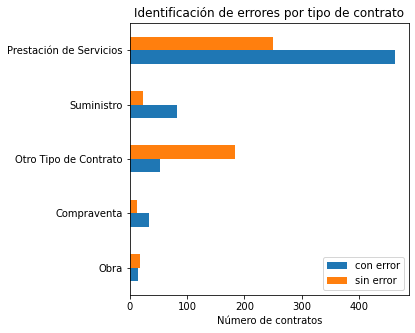

In [45]:
secop_i.groupby(['tipo_contrato', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .tail(5)\
        .plot(kind = 'barh', figsize = (5, 5),
        title = 'Identificación de errores por tipo de contrato')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

Con respecto al orden de la entidad se presenta un caso igual de significativo al observar la gráfica de abajo. Los contratos que presentan una proporción de datos erroneos se presentan en los niveles territoriales más bajos, esa así que en el nivel municipal 6 la proporción de valores erroneos es más del 70%, por otro lado, los contratos en el orden territorial departamental descentralizados presenta la mayor frecuencia de los contratos, donde esta categoría presenta una cantidad de contratos erroneos mayor a los que no presentan ninguna anomalía. 

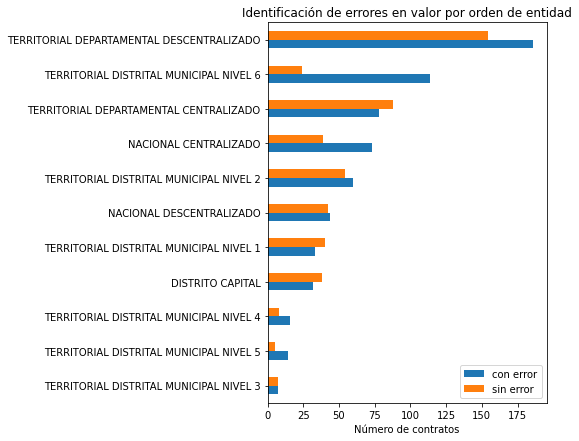

In [46]:
secop_i.groupby(['orden_entidad', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .plot(kind = 'barh', figsize = (5, 7),
        title = 'Identificación de errores en valor por orden de entidad')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

En relación al departamento de la entidad se presenta una tendencia para cada una de las regiones. En la siguiente gráfica se puede ver que en la mayoria de los departamentos existe una mayor porporción de contratos con error, los únicos casos excepcionales ocurre con Bogotá, Atlántico y Quindio. Sin embargo, esta proporción se presenta de mayor grado en los departamentos de Boyacá, Huila, Tolima, Risaralda y cauca, entre otros.

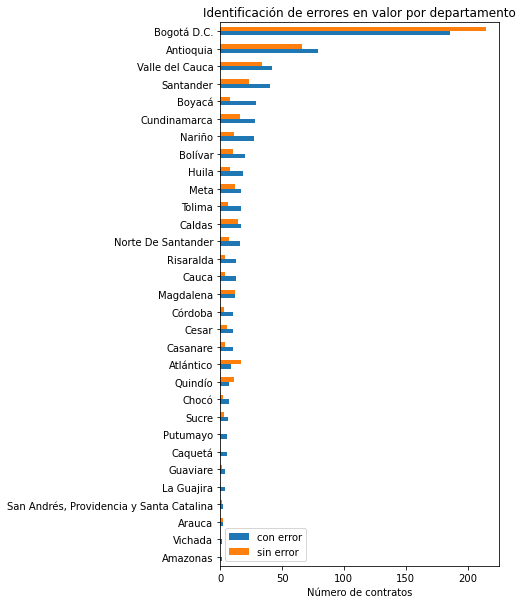

In [47]:
secop_i.groupby(['dpto_entidad', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .plot(kind = 'barh', figsize = (5, 10),
        title = 'Identificación de errores en valor por departamento')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

Ahora bien con respecto al SECOP II se pueden obtener caraterísticas similares a las anteriores. Con respecto al tipo de contrato, se observa que la prestación de servicios tiene una cantidad de error menor con relación a los contrato sin error, aunque de igual forma que en SECOP I son la modalidad más propensas. De igual forma se observa con las demás modalidades. La que presenta una relación casi en la mitad son los contratos bajo el decreto 092 del 2017.

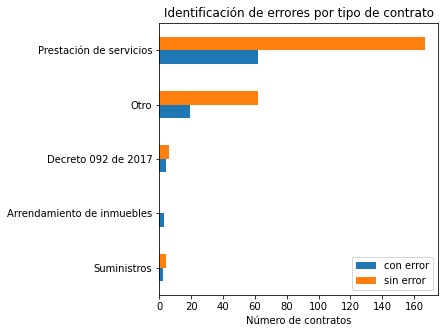

In [48]:
secop_ii.groupby(['tipo_contrato', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .tail(5)\
        .plot(kind = 'barh', figsize = (5, 5),
        title = 'Identificación de errores por tipo de contrato')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

En el orden de la entidad se presenta un comportamiento diferente al de la anterior plataforma, ya que en la gráfica se observa que existen contratos del orden nacional que presentan mayor cantida de contratos con error que el orden territorial.

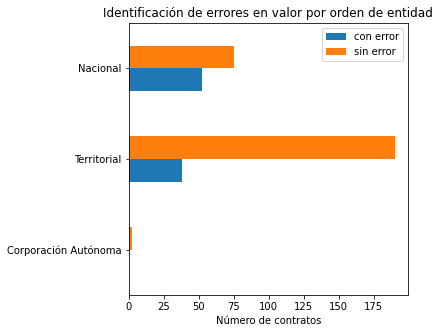

In [49]:
secop_ii.groupby(['orden_entidad', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .plot(kind = 'barh', figsize = (5, 5),
        title = 'Identificación de errores en valor por orden de entidad')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

Por último, a nivel departamental se presentan una concentración de contratos en Bogotá y Antioquia, por lo que en algunos departamentos resulta en que todos los contratos revisados presentaron un error. Sin embargo, son tan pocos como para inferir un alto riesgo cometer estos errores. Cabe resaltar que en Antioquia la cantidad de contratos con error es relativamente mayor que en Bogotá, por lo tanto, es más probable encontrar un error por valor en ese departamento.

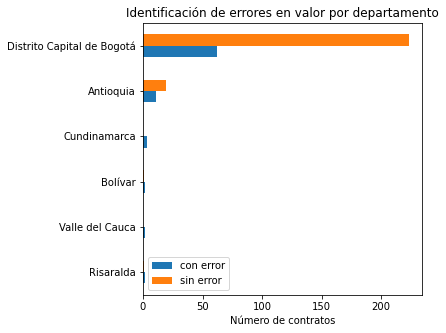

In [50]:
secop_ii.groupby(['dpto_entidad', 'es_error'])['es_error']\
        .count()\
        .unstack('es_error')\
        .fillna(0)\
        .sort_values(by = 'con error')\
        .tail(6)\
        .plot(kind = 'barh', figsize = (5, 5),
        title = 'Identificación de errores en valor por departamento')
        
plt.xlabel('Número de contratos')
plt.ylabel('')
plt.legend(title = '')

## Efectividad de las consultas
Con el fin de determinar un indicador de rendimiento al estudio se establecen una tasa de efectividad para cada una de las consultas propuestas, de tal manera de proponer cual deberia ser mejorada o descartada.

Con respecto a las consultas de SECOP I se obtuvieron resultados importantes, debido a que en general se indentificaron un 56.8% de contratos con error, sin embargo, al análizar la tasa de efectividad para cada una de las consultas presentes en la siguiente tabla, se puede observar como la consulta de _Diferencia cuantia proceso y valor contrato_ presenta un valor del 79.1%, lo que es bastante aceptable para un primer diseño, seguidamente estan las consultas de _ceros adicionales_ (60.5%) y _adiciones altas y bajas_ (48.8%). Más abajo se presentan los contratos con _cuantía contrato cercano a cero_ (32.5%) lo que resulta en la consulta más baja y la que reduce significativamente el promedio de las demás consultas.

In [51]:
secop_i.assign(es_error = secop_i['rel_error']\
    .map(lambda rel_error: True if rel_error != 'ninguna' else False))\
        .groupby('tipo_consulta')['es_error']\
        .mean()\
        .sort_values(ascending = False) * 100

tipo_consulta
Diferencia cuantia proceso y valor contrato    79.104478
Ceros adicionales                              60.469314
Adiciones altas y bajas                        48.756219
Cuantia contrato cercano a cero                32.500000
Name: es_error, dtype: float64

En SECOP II las consultas presentan un promedio del 25.2%, lo que resulta muy baja a comparación del SECOP I, sin embargo, al observar la tasa de efectividad por consulta hay una diferencia grande entre cada una. La consulta de _cuantía contrato cercano a cero_ tiene la mayor proporción con un 44%, seguidamente está la consulta de _ceros adicionales_ con un 29.82%, por último, en la consulta de _adiciones altas y bajas_ solo presento casos de errores en un 4.6%, es claro que esta consulta no refleja un buen resultado.

In [53]:
secop_ii.assign(es_error = secop_ii['rel_error']\
    .map(lambda rel_error: True if rel_error != 'ninguna' else False))\
        .groupby('tipo_consulta')['es_error']\
        .mean()\
        .sort_values(ascending = False) * 100

tipo_consulta
Cuantia contrato cercano a cero    44.000000
Ceros adicionales                  29.824561
Adiciones altas y bajas             4.666667
Name: es_error, dtype: float64

No obstante, durante la revisión se encontró una serie de contratos que tienen la misma característica y por su estructura pueden estar bajo un proceso específico, aunque hayan sido capturadas por las consultas. Estos contratos hacen referencia a contratos de prestación de servicios por la entidad Subred de Bogotá. La cuestión es que estos contratos presentan adiciones muy altas debido a que se renueva demasiados los contratos, ocasionando la desproporcionalidad entre el valor inicial y las adiciones.
A partir de esto se recalculó las tasas descartando estos contratos de subred y se obtuvo un incremento leve con respecto a SECOP I, donde el promedio subió casi dos puntos, especificamente al 58.6%.

In [55]:
secop_i[~((secop_i['nombre_entidad'].str.lower().str.contains('subred')) &
        (secop_i['es_error'] == 'sin error'))]\
    .assign(es_error = secop_i['rel_error']\
    .map(lambda rel_error: True if rel_error != 'ninguna' else False))\
        .groupby('tipo_consulta')['es_error']\
        .mean()\
        .sort_values(ascending = False) * 100

tipo_consulta
Diferencia cuantia proceso y valor contrato    79.104478
Ceros adicionales                              60.688406
Adiciones altas y bajas                        57.647059
Cuantia contrato cercano a cero                32.663317
Name: es_error, dtype: float64

Por otro lado, en SECOP II las tasas mejoraron significativamente hasta llegar a un 42.3%, aumentando un poco más de 17 puntos. En este caso las consultas aumentaron sus porcentajes, pero la consulta de _ceros adicionales_ aumento considerablemente de hasta un 29.8%.

In [59]:
secop_ii[~((secop_ii['nombre_entidad'].str.lower().str.contains('subred')) &
        (secop_ii['es_error'] == 'sin error'))]\
    .assign(es_error = secop_ii['rel_error']\
    .map(lambda rel_error: True if rel_error != 'ninguna' else False))\
        .groupby('tipo_consulta')['es_error']\
        .mean()\
        .sort_values(ascending = False) * 100

tipo_consulta
Adiciones altas y bajas            63.636364
Cuantia contrato cercano a cero    45.517241
Ceros adicionales                  29.824561
Name: es_error, dtype: float64

## Conclusiones
* Las consultas diseñadas permiten identificar contratos con errores en valor. Aunque se presentan consultas con tasas de efectividad bajas, se pueden hacer un rediseño que mejoren los resultados.
* La revisión manual permitió obtener información adicional acerca de cómo se generan los erroes y permite mejorar las consultas, por ejemplo, se identificó que los contratos de subred son una forma particular en sus procesos de contratación y se pueden descartar de este tipo de análisis.
* Existe una variación significativa en los tipos de error y los atributos característicos de la entidad, lo que puede presentar una oportunidad para realizar un proceso predictivo para estos errores.